# Neural Thompson Sampling

<img src="./Figure/algorithm1.png" style="zoom:80%" />

<img src="./Figure/Loss_Function.png" style="zoom:80%" />

This paper prove the bound of expected regret bound, but it directly apply its algorithm on the classification problem, without a testing on online learning theorem.

It might be quite hard to compare its performance on online learning theory.

we set the real reward := 2 * np.exp(A^T context) / (1 + np.exp(A^T context)) - 1 + np.random.normal(loc=0, scale=1)

In [1]:
%reset -f
import numpy as np
import random
from copy import deepcopy
from GameSetting import *
from NeuralNetworkRelatedFunction import *

In [2]:
class NeuralAgent:
    def __init__(self, K, T, d, L = 2, m = 20, v = 0.1, lambda_ = 0.01, eta = 0.001, frequency = 50, batchsize = None):
        # K is Total number of actions,
        # T is Total number of periods
        # d is the dimension of context
        self.K = K
        self.T = T
        self.d = d
        
        self.L = L
        self.m = m
        self.v = v
        self.lambda_ = lambda_
        self.eta = eta
        self.frequency = frequency # we train the network after frequency, e.g. per 50 round
        self.batchsize = batchsize
        self.t = 0 # marks the index of period
        self.history_reward = np.zeros(T)
        self.history_action = np.zeros(T)
        self.predicted_reward = np.zeros(T)
        self.history_context = np.zeros((d, T))
        
        # initialize the value of parameter
        np.random.seed(12345)
        self.theta_0 = {}
        W = np.random.normal(loc = 0, scale = 4 / m, size=(int(m/2), int(m/2)))
        w = np.random.normal(loc = 0, scale = 2 / m, size=(1, int(m/2)))
        for key in range(1, L + 1):
            if key == 1:
                # this paper doesn't present the initialization of w1
                # in its setting, d = m, then he let theta_0["w1"]=[W,0;0,W]
                # but in fact d might not equal to m
                tempW = np.random.normal(loc = 0, scale = 4 / m, size=(int(m/2), int(d/2)))
                self.theta_0["w1"] = np.zeros((m, d))
                self.theta_0["w1"][0:int(m/2), 0:int(d/2)] = tempW
                self.theta_0["w1"][int(m/2):, int(d/2):] = tempW
            elif 2 <= key and key <= L - 1:
                self.theta_0["w" + str(key)] = np.zeros((m, m))
                self.theta_0["w" + str(key)][0:int(m/2), 0:int(m/2)] = W
                self.theta_0["w" + str(key)][int(m/2):, int(m/2):] = W
            else:
                self.theta_0["w" + str(key)] = np.concatenate([w, -w], axis = 1)
                
        self.p = m + m * d + m * m * (L - 2)
        self.params = deepcopy(self.theta_0)
        self.U = lambda_ * np.eye(self.p)
        self.params_history = {}
        self.grad_history = {}
    
    def Action(self, context_list):
        # context_list is a d*K matrix, each column represent a context
        # the return value is the action we choose, represent the index of action, is a scalar
        sample_estimated_reward = np.zeros(K) # the upper bound of K actions
        predict_reward = np.zeros(K)
        U_inverse = np.linalg.inv(self.U)
        for a in range(1, K + 1):
            predict_reward[a - 1] = NeuralNetwork(context_list[:, a - 1], self.params, self.L, self.m)['x' + str(self.L)][0]
            grad_parameter = GradientNeuralNetwork(context_list[:, a - 1], self.params, self.L, self.m)
            grad_parameter = FlattenDict(grad_parameter, self.L)
            sigma_square = self.lambda_ * grad_parameter.dot(U_inverse).dot(grad_parameter) / self.m
            sigma = np.sqrt(sigma_square)
            
            sample_estimated_reward[a - 1] = np.random.normal(loc = predict_reward[a - 1], scale = self.v * sigma)
            
        ind = np.argmax(sample_estimated_reward, axis=None)
        self.predicted_reward[self.t] = sample_estimated_reward[ind]
        self.history_action[self.t] = ind
        self.history_context[:, self.t] = context_list[:, ind]
        return ind
    
    def Update(self, reward):
        # reward is the realized reward after we adopt policy, a scalar
#         print("round {:d}".format(self.t))
        self.history_reward[self.t] = reward
        ind = self.history_action[self.t]
        context = self.history_context[:, self.t]
        
        # compute Z_t_minus1
        grad_parameter = GradientNeuralNetwork(context, self.params, self.L, self.m)
        grad_parameter = FlattenDict(grad_parameter, self.L)
        grad_parameter = np.expand_dims(grad_parameter, axis = 1)
        self.U = self.U + grad_parameter.dot(grad_parameter.transpose()) / self.m

        # train neural network
        if self.t % self.frequency == 0 and self.t > 0:
            J = self.t
        else:
            J = 0
            
        if self.batchsize == None:
            trainindex = range(0, self.t + 1)
        else:
            if self.batchsize > self.t + 1:
                trainindex = range(0, self.t + 1)
            else:
                trainindex = random.sample(range(0, self.t + 1), self.batchsize)
                
        grad_loss = {}
        for j in range(J):
            
            grad_loss = GradientLossFunction(self.history_context[:, trainindex],# we had not update self.t yet, so here we must +1
                                             self.params, 
                                             self.L, 
                                             self.m, 
                                             self.history_reward[trainindex], 
                                             self.theta_0, 
                                             self.lambda_)
#             if j < 10:
#                 eta = 1e-4
#             else:
#                 eta = self.eta
            eta = self.eta
            for key in self.params.keys():
                self.params[key] = self.params[key] - eta * grad_loss[key]
            loss = LossFunction(self.history_context[:, trainindex],
                            self.params, 
                            self.L, 
                            self.m,
                            self.history_reward[trainindex],
                            self.theta_0,
                            self.lambda_)
#             print("j {:d}, loss {:4f}".format(j, loss))
        
        print("round {:d}, predicted reward {:4f}, actual reward {:4f}".format(self.t,
                                                                               self.predicted_reward[self.t], 
                                                                               reward))

        self.params_history[self.t] = deepcopy(self.params)
        self.grad_history[self.t] = deepcopy(grad_loss)
        
        self.t = self.t + 1    

In [3]:
class BestAgent:
    def __init__(self, K, T, d):
        # K is Total number of actions,
        # T is Total number of periods
        # d is the dimension of context
        self.K = K
        self.T = T
        self.d = d
        self.t = 0 # marks the index of period
        self.history_reward = np.zeros(T)
        self.history_action = np.zeros(T)
        self.history_context = np.zeros((d, T))
    
    def Action(self, context_list):
        # context_list is a d*K matrix, each column represent a context
        # the return value is the action we choose, represent the index of action, is a scalar
        
        expected_reward = np.zeros(K)
        for kk in range(0, K):
            context = context_list[:, kk]
            innerproduct = A.dot(context)
            expected_reward[kk] = 2 * np.exp(innerproduct) / (1 + np.exp(innerproduct))
        ind = np.argmax(expected_reward, axis=None)
        self.history_context[:, self.t] = context_list[:, ind]
        self.history_action[self.t] = ind
        return ind
    
    def Update(self, reward):
        # reward is the realized reward after we adopt policy, a scalar
        self.history_reward[self.t] = reward
        self.t = self.t + 1

In [4]:
class UniformAgent:
    def __init__(self, K, T, d):
        # K is Total number of actions,
        # T is Total number of periods
        # d is the dimension of context
        self.K = K
        self.T = T
        self.d = d
        self.t = 0 # marks the index of period
        self.history_reward = np.zeros(T)
        self.history_action = np.zeros(T)
        self.history_context = np.zeros((d, T))
    
    def Action(self, context_list):
        # context_list is a d*K matrix, each column represent a context
        # the return value is the action we choose, represent the index of action, is a scalar
        
        ind = np.random.randint(0, high = K) # we just uniformly choose an action
        self.history_context[:, self.t] = context_list[:, ind]
        return ind
    
    def Update(self, reward):
        # reward is the realized reward after we adopt policy, a scalar
        self.history_reward[self.t] = reward
        self.t = self.t + 1
        
    def GetHistoryReward(self):
        return self.history_reward
    
    def GetHistoryAction(self):
        return self.history_action
    
    def GetHistoryContext(self):
        return self.history_context

In [5]:
# Set the parameter of the game
np.random.seed(12345)
K = 4# Total number of actions, 
T = 5000 # Total number of periods
d = 10 # the dimension of context
A = np.random.normal(loc=0, scale=1, size = d)

In [6]:
# Neural Thompson sampling
np.random.seed(12345)

# Set the parameter of the network
# the setting is based on the description of section 7.1 of the papaer
L = 2
m = 10 
v = 0.1 #{0.01, 0.1, 1}
lambda_ = 1 #{0.1, 1, 10}
eta = 1e-4 #{0.001, 0.01, 0.1}
frequency = 50
batchsize = 500
# we set J equal to round index t

neuralagent = NeuralAgent(K, T, d, L, m, v, lambda_, eta, frequency, batchsize)
for tt in range(1, T + 1):
    # observe \{x_{t,a}\}_{a=1}^{k=1}
    context_list = SampleContext(d, K)
    
    # compute the upper bound of reward
    ind = neuralagent.Action(context_list)
    
    # play ind and observe reward
    reward = GetRealReward(context_list[:, ind], A)
    neuralagent.Update(reward)

round 0, predicted reward 0.148176, actual reward 0.244740
round 1, predicted reward 0.022844, actual reward 0.563030
round 2, predicted reward 0.292856, actual reward 0.195210
round 3, predicted reward 0.034788, actual reward 0.261966
round 4, predicted reward 0.241494, actual reward 0.547694
round 5, predicted reward 0.294280, actual reward 0.403253
round 6, predicted reward 0.157398, actual reward 0.201512
round 7, predicted reward 0.306764, actual reward 0.100068
round 8, predicted reward 0.069192, actual reward 0.414156
round 9, predicted reward 0.196820, actual reward 0.166924
round 10, predicted reward 0.311780, actual reward 0.073694
round 11, predicted reward 0.388526, actual reward 0.606803
round 12, predicted reward 0.176393, actual reward 0.417585
round 13, predicted reward 0.080025, actual reward -0.422391
round 14, predicted reward 0.226923, actual reward -0.036049
round 15, predicted reward 0.149136, actual reward 0.153878
round 16, predicted reward 0.296422, actual rewa

round 150, predicted reward 0.047657, actual reward 0.161311
round 151, predicted reward 0.498842, actual reward 0.589868
round 152, predicted reward 0.562597, actual reward 0.689453
round 153, predicted reward 0.519010, actual reward 0.619855
round 154, predicted reward 0.331904, actual reward -0.006165
round 155, predicted reward 0.170229, actual reward 0.266145
round 156, predicted reward 0.092881, actual reward -0.262930
round 157, predicted reward 0.403350, actual reward 0.662577
round 158, predicted reward 0.152804, actual reward 0.396145
round 159, predicted reward 0.056459, actual reward 0.448996
round 160, predicted reward 0.392784, actual reward 0.706085
round 161, predicted reward 0.073751, actual reward 0.562014
round 162, predicted reward 0.049605, actual reward -0.443878
round 163, predicted reward 0.174470, actual reward -0.164901
round 164, predicted reward 0.400843, actual reward 0.543162
round 165, predicted reward 0.000000, actual reward -0.388544
round 166, predicte

round 300, predicted reward 0.160261, actual reward 0.524058
round 301, predicted reward 0.960720, actual reward 0.825085
round 302, predicted reward -0.044614, actual reward -0.421719
round 303, predicted reward 0.211535, actual reward 0.318759
round 304, predicted reward 0.402926, actual reward 0.389835
round 305, predicted reward 0.560345, actual reward 0.587269
round 306, predicted reward 0.474391, actual reward 0.623295
round 307, predicted reward 0.310300, actual reward 0.503637
round 308, predicted reward 0.325661, actual reward 0.491110
round 309, predicted reward -0.122650, actual reward -0.107679
round 310, predicted reward 0.306985, actual reward 0.439540
round 311, predicted reward 0.153053, actual reward 0.222338
round 312, predicted reward 0.500340, actual reward 0.515855
round 313, predicted reward 0.310999, actual reward 0.166405
round 314, predicted reward -0.046827, actual reward -0.045311
round 315, predicted reward 0.327031, actual reward 0.551954
round 316, predict

round 450, predicted reward 0.543702, actual reward 0.508894
round 451, predicted reward 0.261578, actual reward 0.424762
round 452, predicted reward 0.085629, actual reward 0.104987
round 453, predicted reward 0.633721, actual reward 0.591006
round 454, predicted reward 0.923504, actual reward 0.809851
round 455, predicted reward 0.077493, actual reward -0.114694
round 456, predicted reward 0.435135, actual reward 0.478145
round 457, predicted reward 0.050206, actual reward -0.014185
round 458, predicted reward 0.046194, actual reward -0.036608
round 459, predicted reward 0.142220, actual reward 0.210214
round 460, predicted reward 0.534923, actual reward 0.615374
round 461, predicted reward 0.619065, actual reward 0.589684
round 462, predicted reward 0.578056, actual reward 0.586928
round 463, predicted reward 0.661628, actual reward 0.668814
round 464, predicted reward 0.391141, actual reward 0.521495
round 465, predicted reward -0.059002, actual reward -0.066752
round 466, predicte

round 600, predicted reward 0.488547, actual reward 0.563314
round 601, predicted reward 0.590690, actual reward 0.613863
round 602, predicted reward 0.356712, actual reward 0.369770
round 603, predicted reward 0.445085, actual reward 0.398275
round 604, predicted reward 0.003544, actual reward -0.055323
round 605, predicted reward 0.496646, actual reward 0.595639
round 606, predicted reward 0.433903, actual reward 0.498875
round 607, predicted reward 0.057861, actual reward 0.142500
round 608, predicted reward 0.259185, actual reward 0.311931
round 609, predicted reward 0.041492, actual reward 0.113785
round 610, predicted reward 0.374011, actual reward 0.409090
round 611, predicted reward -0.033327, actual reward -0.474099
round 612, predicted reward 0.662477, actual reward 0.725152
round 613, predicted reward 0.486073, actual reward 0.528549
round 614, predicted reward 0.211893, actual reward 0.252763
round 615, predicted reward 0.000000, actual reward -0.371616
round 616, predicted

round 750, predicted reward 0.555028, actual reward 0.625673
round 751, predicted reward 0.593013, actual reward 0.593691
round 752, predicted reward 0.444019, actual reward 0.440440
round 753, predicted reward 0.662177, actual reward 0.645619
round 754, predicted reward 0.369522, actual reward 0.455418
round 755, predicted reward 0.192528, actual reward 0.263313
round 756, predicted reward 0.488251, actual reward 0.588818
round 757, predicted reward 0.003750, actual reward -0.154713
round 758, predicted reward 0.560720, actual reward 0.469725
round 759, predicted reward 0.409413, actual reward 0.481975
round 760, predicted reward 0.215448, actual reward 0.211709
round 761, predicted reward 0.322340, actual reward 0.332785
round 762, predicted reward 0.611983, actual reward 0.629030
round 763, predicted reward 0.675309, actual reward 0.649920
round 764, predicted reward 0.473765, actual reward 0.513095
round 765, predicted reward 0.486921, actual reward 0.544059
round 766, predicted re

round 900, predicted reward 0.473521, actual reward 0.451053
round 901, predicted reward 0.122004, actual reward 0.171236
round 902, predicted reward 0.527532, actual reward 0.582123
round 903, predicted reward 0.413119, actual reward 0.473998
round 904, predicted reward -0.030425, actual reward -0.259081
round 905, predicted reward 0.484651, actual reward 0.568585
round 906, predicted reward 0.818884, actual reward 0.778366
round 907, predicted reward 0.200777, actual reward 0.173373
round 908, predicted reward 0.388166, actual reward 0.347197
round 909, predicted reward 0.310193, actual reward 0.353165
round 910, predicted reward 0.163883, actual reward 0.175803
round 911, predicted reward 0.335384, actual reward 0.406237
round 912, predicted reward 0.257275, actual reward 0.294807
round 913, predicted reward 0.771661, actual reward 0.701415
round 914, predicted reward 0.721125, actual reward 0.706225
round 915, predicted reward 0.847087, actual reward 0.783905
round 916, predicted r

round 1050, predicted reward 0.552171, actual reward 0.552819
round 1051, predicted reward 0.506811, actual reward 0.575258
round 1052, predicted reward 0.777831, actual reward 0.745343
round 1053, predicted reward 0.089030, actual reward 0.006145
round 1054, predicted reward 0.769700, actual reward 0.744562
round 1055, predicted reward 0.410739, actual reward 0.414593
round 1056, predicted reward 0.436533, actual reward 0.461539
round 1057, predicted reward 0.057628, actual reward 0.012805
round 1058, predicted reward 0.443350, actual reward 0.391536
round 1059, predicted reward 0.491715, actual reward 0.603993
round 1060, predicted reward 0.308854, actual reward 0.363801
round 1061, predicted reward 0.438010, actual reward 0.549303
round 1062, predicted reward 0.279121, actual reward 0.307785
round 1063, predicted reward 0.346047, actual reward 0.339676
round 1064, predicted reward 0.690130, actual reward 0.732528
round 1065, predicted reward 0.134524, actual reward 0.186857
round 10

round 1200, predicted reward 0.249708, actual reward 0.350957
round 1201, predicted reward 0.607922, actual reward 0.615020
round 1202, predicted reward 0.043111, actual reward -0.056868
round 1203, predicted reward 0.465915, actual reward 0.531065
round 1204, predicted reward -0.004716, actual reward -0.213845
round 1205, predicted reward 0.041271, actual reward -0.188751
round 1206, predicted reward 0.688896, actual reward 0.670876
round 1207, predicted reward 0.210948, actual reward 0.181372
round 1208, predicted reward 0.257102, actual reward 0.174655
round 1209, predicted reward 0.425372, actual reward 0.498673
round 1210, predicted reward 0.644613, actual reward 0.654169
round 1211, predicted reward 0.206341, actual reward 0.262530
round 1212, predicted reward 0.592196, actual reward 0.603510
round 1213, predicted reward 0.385096, actual reward 0.429748
round 1214, predicted reward 0.253780, actual reward 0.316672
round 1215, predicted reward 0.775904, actual reward 0.719999
roun

round 1350, predicted reward 0.303026, actual reward 0.324850
round 1351, predicted reward 0.304234, actual reward 0.366297
round 1352, predicted reward 0.152076, actual reward 0.070340
round 1353, predicted reward 0.607394, actual reward 0.634242
round 1354, predicted reward 0.287390, actual reward 0.306320
round 1355, predicted reward 0.521123, actual reward 0.531642
round 1356, predicted reward 0.448538, actual reward 0.430298
round 1357, predicted reward 0.477400, actual reward 0.517660
round 1358, predicted reward 0.304014, actual reward 0.331787
round 1359, predicted reward 0.026973, actual reward 0.062568
round 1360, predicted reward 0.413078, actual reward 0.479162
round 1361, predicted reward 0.603199, actual reward 0.647957
round 1362, predicted reward 0.323912, actual reward 0.379410
round 1363, predicted reward 0.407904, actual reward 0.444616
round 1364, predicted reward 0.324616, actual reward 0.408266
round 1365, predicted reward 0.325712, actual reward 0.363534
round 13

round 1500, predicted reward 0.040256, actual reward -0.126348
round 1501, predicted reward 0.481399, actual reward 0.495564
round 1502, predicted reward 0.585144, actual reward 0.578483
round 1503, predicted reward 0.464889, actual reward 0.523900
round 1504, predicted reward 0.498461, actual reward 0.617163
round 1505, predicted reward 0.289255, actual reward 0.398787
round 1506, predicted reward 0.491801, actual reward 0.475698
round 1507, predicted reward 0.551978, actual reward 0.660718
round 1508, predicted reward 0.483830, actual reward 0.493134
round 1509, predicted reward 0.009135, actual reward -0.594026
round 1510, predicted reward 0.421917, actual reward 0.514369
round 1511, predicted reward 0.436444, actual reward 0.544848
round 1512, predicted reward 0.022497, actual reward 0.084818
round 1513, predicted reward 0.483080, actual reward 0.577864
round 1514, predicted reward 0.051585, actual reward 0.046340
round 1515, predicted reward 0.408231, actual reward 0.442234
round 

round 1650, predicted reward 0.602163, actual reward 0.615016
round 1651, predicted reward 0.367600, actual reward 0.378760
round 1652, predicted reward 0.650847, actual reward 0.674749
round 1653, predicted reward 0.335800, actual reward 0.434099
round 1654, predicted reward -0.055102, actual reward -0.376396
round 1655, predicted reward -0.025219, actual reward -0.373714
round 1656, predicted reward 0.536359, actual reward 0.553365
round 1657, predicted reward 0.265927, actual reward 0.394924
round 1658, predicted reward 0.378578, actual reward 0.427252
round 1659, predicted reward -0.058936, actual reward -0.092856
round 1660, predicted reward -0.122553, actual reward -0.508717
round 1661, predicted reward 0.557160, actual reward 0.573069
round 1662, predicted reward -0.030949, actual reward -0.145549
round 1663, predicted reward 0.579971, actual reward 0.639588
round 1664, predicted reward 0.702466, actual reward 0.701242
round 1665, predicted reward 0.378961, actual reward 0.44409

round 1800, predicted reward 0.028408, actual reward -0.501091
round 1801, predicted reward 0.386246, actual reward 0.378529
round 1802, predicted reward 0.103760, actual reward 0.148213
round 1803, predicted reward 0.174892, actual reward 0.172928
round 1804, predicted reward 0.583885, actual reward 0.639010
round 1805, predicted reward 0.334539, actual reward 0.342485
round 1806, predicted reward 0.709820, actual reward 0.696722
round 1807, predicted reward 0.248612, actual reward 0.311943
round 1808, predicted reward 0.595914, actual reward 0.605358
round 1809, predicted reward 0.709124, actual reward 0.705289
round 1810, predicted reward 0.077225, actual reward 0.056542
round 1811, predicted reward 0.576386, actual reward 0.614466
round 1812, predicted reward 0.835014, actual reward 0.765113
round 1813, predicted reward 0.257511, actual reward 0.270807
round 1814, predicted reward 0.078561, actual reward -0.177414
round 1815, predicted reward 0.002787, actual reward -0.188837
round

round 1950, predicted reward 0.369662, actual reward 0.413895
round 1951, predicted reward 0.162243, actual reward 0.115415
round 1952, predicted reward 0.475554, actual reward 0.516991
round 1953, predicted reward 0.512132, actual reward 0.542292
round 1954, predicted reward 0.388499, actual reward 0.439710
round 1955, predicted reward 0.613226, actual reward 0.686618
round 1956, predicted reward 0.276514, actual reward 0.400162
round 1957, predicted reward 0.553182, actual reward 0.541477
round 1958, predicted reward 0.224905, actual reward 0.204374
round 1959, predicted reward 0.238643, actual reward 0.267064
round 1960, predicted reward 0.964385, actual reward 0.808061
round 1961, predicted reward 0.706399, actual reward 0.700712
round 1962, predicted reward 0.685488, actual reward 0.699497
round 1963, predicted reward 0.507880, actual reward 0.556019
round 1964, predicted reward 0.303558, actual reward 0.343369
round 1965, predicted reward 0.216320, actual reward 0.308696
round 19

round 2100, predicted reward 0.512682, actual reward 0.550311
round 2101, predicted reward 0.296650, actual reward 0.365326
round 2102, predicted reward 0.605674, actual reward 0.614100
round 2103, predicted reward 0.288670, actual reward 0.338121
round 2104, predicted reward 0.683129, actual reward 0.714256
round 2105, predicted reward 0.881875, actual reward 0.773823
round 2106, predicted reward 0.213867, actual reward 0.295471
round 2107, predicted reward 0.102730, actual reward 0.125125
round 2108, predicted reward 0.024501, actual reward 0.037582
round 2109, predicted reward 0.542909, actual reward 0.567329
round 2110, predicted reward 0.561342, actual reward 0.616745
round 2111, predicted reward 0.570301, actual reward 0.599410
round 2112, predicted reward 0.755912, actual reward 0.697408
round 2113, predicted reward 0.362931, actual reward 0.422158
round 2114, predicted reward 0.509642, actual reward 0.494435
round 2115, predicted reward 0.636176, actual reward 0.678585
round 21

round 2250, predicted reward 0.318578, actual reward 0.433791
round 2251, predicted reward 0.803794, actual reward 0.760798
round 2252, predicted reward 0.193803, actual reward 0.346909
round 2253, predicted reward 0.500227, actual reward 0.552118
round 2254, predicted reward 0.594794, actual reward 0.652701
round 2255, predicted reward 0.864767, actual reward 0.789434
round 2256, predicted reward 0.353941, actual reward 0.493550
round 2257, predicted reward 0.309961, actual reward 0.326944
round 2258, predicted reward 0.631985, actual reward 0.632979
round 2259, predicted reward 0.507110, actual reward 0.535269
round 2260, predicted reward 0.188490, actual reward 0.215110
round 2261, predicted reward 0.612529, actual reward 0.656525
round 2262, predicted reward 0.385200, actual reward 0.390997
round 2263, predicted reward 0.408914, actual reward 0.479934
round 2264, predicted reward 0.380592, actual reward 0.427938
round 2265, predicted reward 0.367132, actual reward 0.463521
round 22

round 2400, predicted reward 0.436361, actual reward 0.470553
round 2401, predicted reward 0.879279, actual reward 0.787361
round 2402, predicted reward 0.058950, actual reward 0.030210
round 2403, predicted reward 0.238080, actual reward 0.300694
round 2404, predicted reward 0.181789, actual reward 0.249411
round 2405, predicted reward 0.262381, actual reward 0.298980
round 2406, predicted reward 0.642089, actual reward 0.661708
round 2407, predicted reward 0.833641, actual reward 0.776040
round 2408, predicted reward 0.324497, actual reward 0.277166
round 2409, predicted reward 0.627605, actual reward 0.644427
round 2410, predicted reward 0.302929, actual reward 0.289209
round 2411, predicted reward 0.303746, actual reward 0.354038
round 2412, predicted reward 0.491411, actual reward 0.543171
round 2413, predicted reward 0.909354, actual reward 0.790404
round 2414, predicted reward 0.782866, actual reward 0.745624
round 2415, predicted reward 0.175879, actual reward 0.246296
round 24

round 2550, predicted reward 0.334073, actual reward 0.416078
round 2551, predicted reward 0.235339, actual reward 0.296319
round 2552, predicted reward 0.468116, actual reward 0.530892
round 2553, predicted reward 0.297139, actual reward 0.307748
round 2554, predicted reward 0.444848, actual reward 0.503520
round 2555, predicted reward 0.784679, actual reward 0.717105
round 2556, predicted reward 0.121101, actual reward 0.211258
round 2557, predicted reward 0.119326, actual reward 0.173319
round 2558, predicted reward 0.630229, actual reward 0.640006
round 2559, predicted reward 0.598195, actual reward 0.603331
round 2560, predicted reward 0.610229, actual reward 0.605427
round 2561, predicted reward 0.459685, actual reward 0.469006
round 2562, predicted reward 0.113645, actual reward 0.038204
round 2563, predicted reward 0.377047, actual reward 0.364250
round 2564, predicted reward 0.394649, actual reward 0.348903
round 2565, predicted reward 0.539779, actual reward 0.597495
round 25

round 2700, predicted reward 0.111925, actual reward 0.125353
round 2701, predicted reward 0.153222, actual reward 0.306923
round 2702, predicted reward 0.634750, actual reward 0.629655
round 2703, predicted reward 0.958916, actual reward 0.831466
round 2704, predicted reward 0.685642, actual reward 0.720056
round 2705, predicted reward 0.527116, actual reward 0.574726
round 2706, predicted reward 0.434121, actual reward 0.412403
round 2707, predicted reward 0.081287, actual reward 0.110635
round 2708, predicted reward 0.426763, actual reward 0.505385
round 2709, predicted reward 0.045430, actual reward -0.157840
round 2710, predicted reward 0.653662, actual reward 0.666403
round 2711, predicted reward 0.636803, actual reward 0.704029
round 2712, predicted reward 0.809370, actual reward 0.756181
round 2713, predicted reward 0.399317, actual reward 0.492477
round 2714, predicted reward 0.080947, actual reward 0.132726
round 2715, predicted reward 0.500628, actual reward 0.571223
round 2

round 2850, predicted reward 0.328157, actual reward 0.335102
round 2851, predicted reward 0.480012, actual reward 0.509974
round 2852, predicted reward 0.835154, actual reward 0.793864
round 2853, predicted reward 0.759870, actual reward 0.714452
round 2854, predicted reward 0.770292, actual reward 0.725978
round 2855, predicted reward 0.462604, actual reward 0.535527
round 2856, predicted reward 0.353954, actual reward 0.423789
round 2857, predicted reward -0.074433, actual reward -0.710270
round 2858, predicted reward 0.275794, actual reward 0.337692
round 2859, predicted reward 0.409024, actual reward 0.489101
round 2860, predicted reward 0.046066, actual reward 0.134397
round 2861, predicted reward 0.608174, actual reward 0.615179
round 2862, predicted reward 0.030023, actual reward 0.070094
round 2863, predicted reward 0.723013, actual reward 0.706739
round 2864, predicted reward 0.137496, actual reward 0.083172
round 2865, predicted reward 0.039211, actual reward 0.008670
round 

round 3000, predicted reward 0.645075, actual reward 0.618126
round 3001, predicted reward 0.617226, actual reward 0.654626
round 3002, predicted reward 0.475085, actual reward 0.498340
round 3003, predicted reward 0.306951, actual reward 0.385637
round 3004, predicted reward 0.458763, actual reward 0.544238
round 3005, predicted reward 0.303321, actual reward 0.351491
round 3006, predicted reward 0.303853, actual reward 0.358507
round 3007, predicted reward 0.310067, actual reward 0.332548
round 3008, predicted reward 0.442265, actual reward 0.518106
round 3009, predicted reward 0.470324, actual reward 0.523379
round 3010, predicted reward 0.626320, actual reward 0.627886
round 3011, predicted reward 0.194842, actual reward 0.228978
round 3012, predicted reward 0.509612, actual reward 0.491779
round 3013, predicted reward 0.077635, actual reward 0.129805
round 3014, predicted reward 0.705037, actual reward 0.690666
round 3015, predicted reward 0.097844, actual reward -0.005666
round 3

round 3150, predicted reward 0.622388, actual reward 0.629379
round 3151, predicted reward 0.508576, actual reward 0.530646
round 3152, predicted reward 0.344240, actual reward 0.330290
round 3153, predicted reward 0.272454, actual reward 0.255236
round 3154, predicted reward 0.265523, actual reward 0.420130
round 3155, predicted reward 0.238263, actual reward 0.329704
round 3156, predicted reward 0.156220, actual reward 0.128174
round 3157, predicted reward 0.529818, actual reward 0.550386
round 3158, predicted reward 0.461229, actual reward 0.440794
round 3159, predicted reward 0.522056, actual reward 0.565075
round 3160, predicted reward 0.774165, actual reward 0.763677
round 3161, predicted reward 0.597879, actual reward 0.661247
round 3162, predicted reward 0.776551, actual reward 0.753085
round 3163, predicted reward 0.865651, actual reward 0.802095
round 3164, predicted reward 0.441505, actual reward 0.496029
round 3165, predicted reward 0.139620, actual reward 0.221740
round 31

round 3300, predicted reward 0.734726, actual reward 0.690965
round 3301, predicted reward 0.298309, actual reward 0.377912
round 3302, predicted reward 0.512116, actual reward 0.566268
round 3303, predicted reward 0.648151, actual reward 0.694572
round 3304, predicted reward 0.139972, actual reward 0.115783
round 3305, predicted reward 0.447817, actual reward 0.538047
round 3306, predicted reward 0.316686, actual reward 0.325013
round 3307, predicted reward 0.081167, actual reward -0.098676
round 3308, predicted reward 0.487492, actual reward 0.494579
round 3309, predicted reward 0.610094, actual reward 0.527591
round 3310, predicted reward 0.943844, actual reward 0.829886
round 3311, predicted reward 0.119497, actual reward 0.145057
round 3312, predicted reward 0.684747, actual reward 0.717217
round 3313, predicted reward -0.006424, actual reward -0.138945
round 3314, predicted reward 0.592534, actual reward 0.591577
round 3315, predicted reward 0.650285, actual reward 0.627334
round

round 3450, predicted reward 0.467087, actual reward 0.529808
round 3451, predicted reward 0.196942, actual reward 0.281788
round 3452, predicted reward 0.182823, actual reward 0.268890
round 3453, predicted reward 0.529025, actual reward 0.585537
round 3454, predicted reward 0.257955, actual reward 0.301791
round 3455, predicted reward 0.383739, actual reward 0.407029
round 3456, predicted reward 0.416330, actual reward 0.460629
round 3457, predicted reward 0.627398, actual reward 0.630710
round 3458, predicted reward 0.227746, actual reward 0.188343
round 3459, predicted reward 0.229291, actual reward 0.307712
round 3460, predicted reward 0.189689, actual reward 0.280428
round 3461, predicted reward 0.484083, actual reward 0.509201
round 3462, predicted reward 0.390470, actual reward 0.452853
round 3463, predicted reward 0.056745, actual reward 0.191229
round 3464, predicted reward 0.545032, actual reward 0.583980
round 3465, predicted reward 0.539185, actual reward 0.595960
round 34

round 3600, predicted reward 0.583507, actual reward 0.573297
round 3601, predicted reward 0.719177, actual reward 0.701687
round 3602, predicted reward 0.638598, actual reward 0.633719
round 3603, predicted reward 0.152494, actual reward 0.098237
round 3604, predicted reward 0.345006, actual reward 0.457849
round 3605, predicted reward 0.119507, actual reward 0.139127
round 3606, predicted reward 0.432719, actual reward 0.478469
round 3607, predicted reward 0.300872, actual reward 0.378008
round 3608, predicted reward 0.638805, actual reward 0.682344
round 3609, predicted reward 0.196963, actual reward 0.222094
round 3610, predicted reward 0.285452, actual reward 0.296027
round 3611, predicted reward 0.599567, actual reward 0.627096
round 3612, predicted reward 0.382144, actual reward 0.437027
round 3613, predicted reward 0.229822, actual reward 0.192114
round 3614, predicted reward 0.452339, actual reward 0.448257
round 3615, predicted reward 0.491845, actual reward 0.488900
round 36

round 3750, predicted reward 0.391702, actual reward 0.479844
round 3751, predicted reward 0.460395, actual reward 0.531769
round 3752, predicted reward 0.067365, actual reward 0.013259
round 3753, predicted reward 0.081111, actual reward 0.058202
round 3754, predicted reward 0.192256, actual reward 0.234629
round 3755, predicted reward 0.511009, actual reward 0.541490
round 3756, predicted reward 0.422466, actual reward 0.492668
round 3757, predicted reward 0.608888, actual reward 0.595680
round 3758, predicted reward 0.255305, actual reward 0.257968
round 3759, predicted reward -0.019197, actual reward -0.386919
round 3760, predicted reward 0.361903, actual reward 0.412596
round 3761, predicted reward 0.507984, actual reward 0.522031
round 3762, predicted reward 0.501569, actual reward 0.531312
round 3763, predicted reward 0.286460, actual reward 0.367583
round 3764, predicted reward 0.240100, actual reward 0.341059
round 3765, predicted reward 0.234981, actual reward 0.252167
round 

round 3900, predicted reward 0.127799, actual reward 0.106495
round 3901, predicted reward 0.630115, actual reward 0.622588
round 3902, predicted reward 0.635848, actual reward 0.633637
round 3903, predicted reward 0.509965, actual reward 0.550743
round 3904, predicted reward 0.255131, actual reward 0.314365
round 3905, predicted reward 0.631665, actual reward 0.651956
round 3906, predicted reward 0.416878, actual reward 0.465273
round 3907, predicted reward 0.768255, actual reward 0.705337
round 3908, predicted reward 0.779382, actual reward 0.740551
round 3909, predicted reward 0.305714, actual reward 0.313683
round 3910, predicted reward 0.787527, actual reward 0.757475
round 3911, predicted reward 0.391329, actual reward 0.389992
round 3912, predicted reward 0.729626, actual reward 0.730495
round 3913, predicted reward 0.207795, actual reward 0.327911
round 3914, predicted reward 0.384265, actual reward 0.374451
round 3915, predicted reward 0.269115, actual reward 0.390738
round 39

round 4050, predicted reward 0.334997, actual reward 0.351889
round 4051, predicted reward 0.203312, actual reward 0.316912
round 4052, predicted reward 0.164375, actual reward 0.158316
round 4053, predicted reward 0.186459, actual reward 0.159941
round 4054, predicted reward 0.178601, actual reward 0.263154
round 4055, predicted reward 0.389213, actual reward 0.375383
round 4056, predicted reward 0.755244, actual reward 0.715709
round 4057, predicted reward 0.614369, actual reward 0.622218
round 4058, predicted reward 0.294507, actual reward 0.261270
round 4059, predicted reward 0.100424, actual reward 0.156619
round 4060, predicted reward 0.637549, actual reward 0.638556
round 4061, predicted reward 0.036076, actual reward -0.114337
round 4062, predicted reward 0.582386, actual reward 0.582604
round 4063, predicted reward 0.152834, actual reward 0.274097
round 4064, predicted reward 0.225134, actual reward 0.288402
round 4065, predicted reward 0.135803, actual reward 0.200156
round 4

round 4200, predicted reward 0.770485, actual reward 0.724651
round 4201, predicted reward 0.406578, actual reward 0.441549
round 4202, predicted reward 0.577246, actual reward 0.571126
round 4203, predicted reward 0.364774, actual reward 0.502632
round 4204, predicted reward 0.333914, actual reward 0.412676
round 4205, predicted reward 0.500241, actual reward 0.541756
round 4206, predicted reward 0.279567, actual reward 0.322602
round 4207, predicted reward 0.298367, actual reward 0.327774
round 4208, predicted reward 0.382245, actual reward 0.450881
round 4209, predicted reward 0.436132, actual reward 0.492687
round 4210, predicted reward 0.390752, actual reward 0.411625
round 4211, predicted reward 0.656168, actual reward 0.665991
round 4212, predicted reward 0.520048, actual reward 0.579040
round 4213, predicted reward 0.262356, actual reward 0.233210
round 4214, predicted reward 0.810072, actual reward 0.759097
round 4215, predicted reward 0.545189, actual reward 0.558254
round 42

round 4350, predicted reward 0.612291, actual reward 0.617403
round 4351, predicted reward 0.303130, actual reward 0.291063
round 4352, predicted reward 0.467733, actual reward 0.522048
round 4353, predicted reward -0.036154, actual reward -0.097117
round 4354, predicted reward 0.591445, actual reward 0.591412
round 4355, predicted reward 0.636731, actual reward 0.680026
round 4356, predicted reward 0.321975, actual reward 0.388757
round 4357, predicted reward 0.555196, actual reward 0.602657
round 4358, predicted reward 0.785778, actual reward 0.755329
round 4359, predicted reward 0.440579, actual reward 0.560730
round 4360, predicted reward 0.366006, actual reward 0.463351
round 4361, predicted reward 0.220016, actual reward 0.281493
round 4362, predicted reward 0.224445, actual reward 0.247050
round 4363, predicted reward 0.222980, actual reward 0.332862
round 4364, predicted reward 0.361699, actual reward 0.408220
round 4365, predicted reward 0.647279, actual reward 0.654386
round 

round 4500, predicted reward 0.134812, actual reward 0.116673
round 4501, predicted reward 0.225548, actual reward 0.275846
round 4502, predicted reward 0.552348, actual reward 0.635596
round 4503, predicted reward 0.564481, actual reward 0.612362
round 4504, predicted reward 0.217421, actual reward 0.196334
round 4505, predicted reward 0.197337, actual reward 0.278113
round 4506, predicted reward 0.024797, actual reward 0.123735
round 4507, predicted reward 0.636710, actual reward 0.650496
round 4508, predicted reward 0.432656, actual reward 0.486061
round 4509, predicted reward 0.215644, actual reward 0.264579
round 4510, predicted reward 0.411067, actual reward 0.430426
round 4511, predicted reward 0.751776, actual reward 0.715459
round 4512, predicted reward 0.231913, actual reward 0.295048
round 4513, predicted reward 0.711288, actual reward 0.688891
round 4514, predicted reward 0.839157, actual reward 0.798589
round 4515, predicted reward 0.261857, actual reward 0.309338
round 45

round 4650, predicted reward 0.590535, actual reward 0.623851
round 4651, predicted reward 0.197797, actual reward 0.239923
round 4652, predicted reward 0.223626, actual reward 0.181381
round 4653, predicted reward 0.230592, actual reward 0.318548
round 4654, predicted reward 0.605921, actual reward 0.645482
round 4655, predicted reward 0.347956, actual reward 0.350261
round 4656, predicted reward 0.072912, actual reward -0.143016
round 4657, predicted reward 0.366017, actual reward 0.436783
round 4658, predicted reward 0.629163, actual reward 0.668500
round 4659, predicted reward 0.648309, actual reward 0.653272
round 4660, predicted reward 0.552319, actual reward 0.584272
round 4661, predicted reward 0.254298, actual reward 0.350506
round 4662, predicted reward 0.212062, actual reward 0.197563
round 4663, predicted reward 0.273984, actual reward 0.353605
round 4664, predicted reward 0.880946, actual reward 0.789681
round 4665, predicted reward 0.652555, actual reward 0.671788
round 4

round 4800, predicted reward 0.730226, actual reward 0.737670
round 4801, predicted reward 0.606858, actual reward 0.625200
round 4802, predicted reward 0.619156, actual reward 0.608110
round 4803, predicted reward 0.275324, actual reward 0.287881
round 4804, predicted reward 0.732802, actual reward 0.717222
round 4805, predicted reward 0.157791, actual reward 0.194032
round 4806, predicted reward 0.421379, actual reward 0.500322
round 4807, predicted reward 0.735510, actual reward 0.716883
round 4808, predicted reward 0.231529, actual reward 0.215309
round 4809, predicted reward 0.094655, actual reward 0.029076
round 4810, predicted reward 0.204782, actual reward 0.188790
round 4811, predicted reward 0.616496, actual reward 0.627197
round 4812, predicted reward 0.176250, actual reward 0.248000
round 4813, predicted reward 0.165843, actual reward 0.176292
round 4814, predicted reward 0.763997, actual reward 0.771529
round 4815, predicted reward 0.777040, actual reward 0.736469
round 48

round 4950, predicted reward 0.113905, actual reward -0.057789
round 4951, predicted reward 0.369848, actual reward 0.458832
round 4952, predicted reward 0.208365, actual reward 0.211448
round 4953, predicted reward 0.260192, actual reward 0.350634
round 4954, predicted reward 0.759562, actual reward 0.690527
round 4955, predicted reward 0.502017, actual reward 0.542777
round 4956, predicted reward 0.030752, actual reward 0.129568
round 4957, predicted reward 0.199314, actual reward 0.196346
round 4958, predicted reward 0.400157, actual reward 0.445164
round 4959, predicted reward 0.104061, actual reward 0.147506
round 4960, predicted reward 0.900059, actual reward 0.774094
round 4961, predicted reward 0.264574, actual reward 0.443340
round 4962, predicted reward 0.034549, actual reward 0.138555
round 4963, predicted reward -0.023720, actual reward -0.094243
round 4964, predicted reward 0.262777, actual reward 0.278648
round 4965, predicted reward 0.271295, actual reward 0.303212
round

In [7]:
# Best agent benchmark
np.random.seed(12345)

# reward = np.zeros(T)
# X_history = np.zeros((d, T))
# params_history = {}
# grad_history = {}

bestagent = BestAgent(K, T, d)
for tt in range(1, T + 1):
    # observe \{x_{t,a}\}_{a=1}^{k=1}
    context_list = SampleContext(d, K)
    
    # compute the upper bound of reward
    ind = bestagent.Action(context_list)
    
    # play ind and observe reward
    reward = GetRealReward(context_list[:, ind], A)
    bestagent.Update(reward)

In [8]:
# Uniform agent benchmark
np.random.seed(12345)

uniformagent = UniformAgent(K, T, d)
for tt in range(1, T + 1):
    # observe \{x_{t,a}\}_{a=1}^{k=1}
    context_list = SampleContext(d, K)
    
    # compute the upper bound of reward
    ind = uniformagent.Action(context_list)
    
    # play ind and observe reward
    reward = GetRealReward(context_list[:, ind], A)
    uniformagent.Update(reward)

Text(0, 0.5, 'Total Reward')

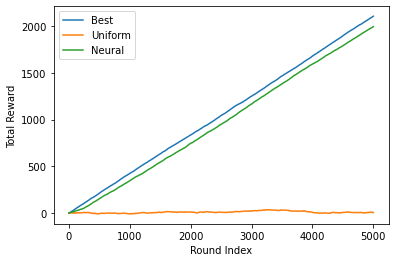

In [9]:
import matplotlib.pyplot as plt
h_r_b = bestagent.history_reward
plt.plot(range(0, T), np.cumsum(h_r_b))

h_r_u = uniformagent.history_reward
plt.plot(range(0, T), np.cumsum(h_r_u))

h_r_n = neuralagent.history_reward
plt.plot(range(0, T), np.cumsum(h_r_n))

plt.legend(["Best", "Uniform", "Neural"])
# plt.legend(["Best", "Uniform"])
plt.xlabel("Round Index")
plt.ylabel("Total Reward")

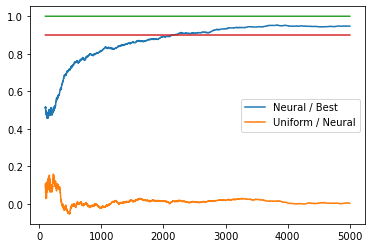

In [10]:
plt.plot(range(100, T), np.cumsum(h_r_n)[100:T] / np.cumsum(h_r_b)[100:T])
plt.plot(range(100, T), np.cumsum(h_r_u)[100:T] / np.cumsum(h_r_n)[100:T])
plt.legend(["Neural / Best", "Uniform / Neural"])
plt.plot(range(100, T), np.ones(T)[100:T])
plt.plot(range(100, T), 0.9 * np.ones(T)[100:T])

we get this result by setting the the real reward function "2 * np.exp(innerproduct) / (1 + np.exp(innerproduct)) - 1"

but it seems that it is still hard to make the curve converge to 1

In [11]:
(np.cumsum(h_r_n)[100:T] / np.cumsum(h_r_b)[100:T])[-10:]

array([0.9476345 , 0.947894  , 0.94778613, 0.94770519, 0.94763804,
       0.94721739, 0.94713434, 0.94721871, 0.9472302 , 0.94733635])

In [12]:
# GetRealReward(np.array([0, 1]), np.array([1, 0]))